# Introduction

In this notebook, I'm demonstrating Recurrent Neural Network for time-series and predictive analysis. Here, I'm using Gated Recurrent Unit(GRU), Long Short Term Memory(LSTM), and Bidirectional Long Short Term Memory(BiLSTM) for comparing their performances on NSE Tata stock market data. Then using the best model I'm predictions for next 5years. 

# Data

**NSE Stock Market** data is used for study. The dataset exhibits daily stock prices from 2010 to 2018 including company's each day opening, closing, high, low, total quantity and  total turnover. 

# Implementation

### Import Libraries

In [1]:
from IPython.core.pylabtools import figsize
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, QuantileTransformer
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Bidirectional, Activation, Dropout
from keras import callbacks
from keras.regularizers import l2
from pandas import DataFrame
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf

### Data Reading & Exploration

In [2]:
Dataset = pd.read_csv('Stock_Data.csv', parse_dates = ['Date'], index_col = 'Date')
Dataset.head()
df = Dataset.copy()

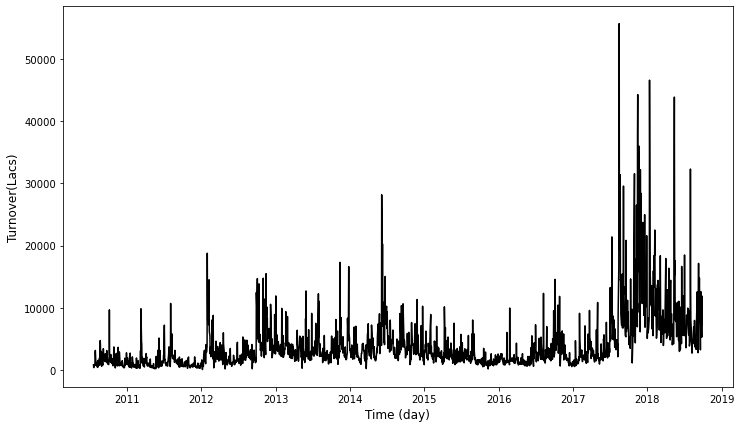

In [3]:
def timeseries (x_axis, y_axis, x_label, y_label):
    plt.figure(figsize = (12, 7))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel(y_label, {'fontsize': 12})
#     plt.savefig('E:/Forecast/1.jpg', format='jpg', dpi=1000)

timeseries(df.index, df['Turnover_Lacs'], 'Time (day)','Turnover(Lacs)')

## Different plots to better understand the data and its distribution

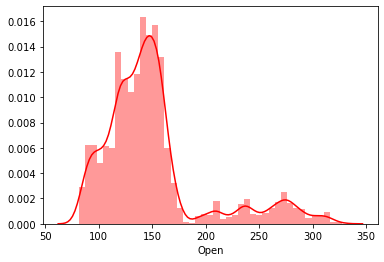

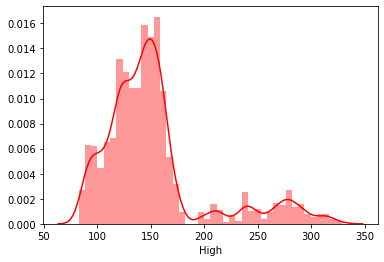

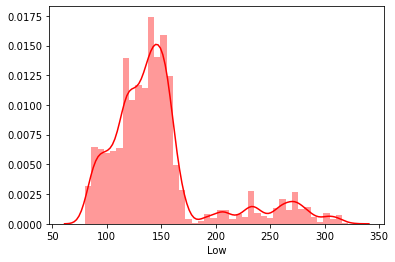

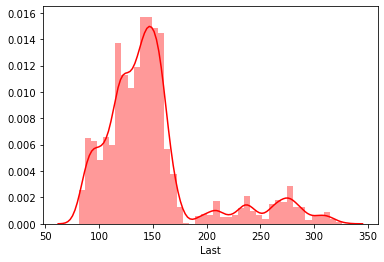

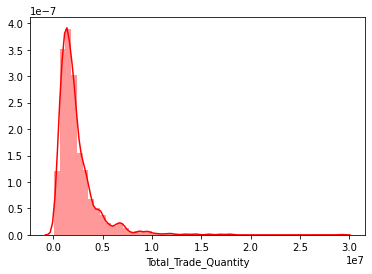

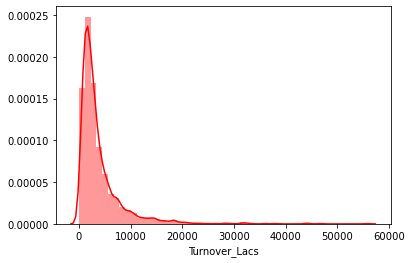

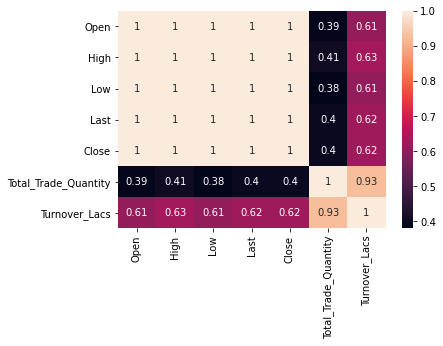

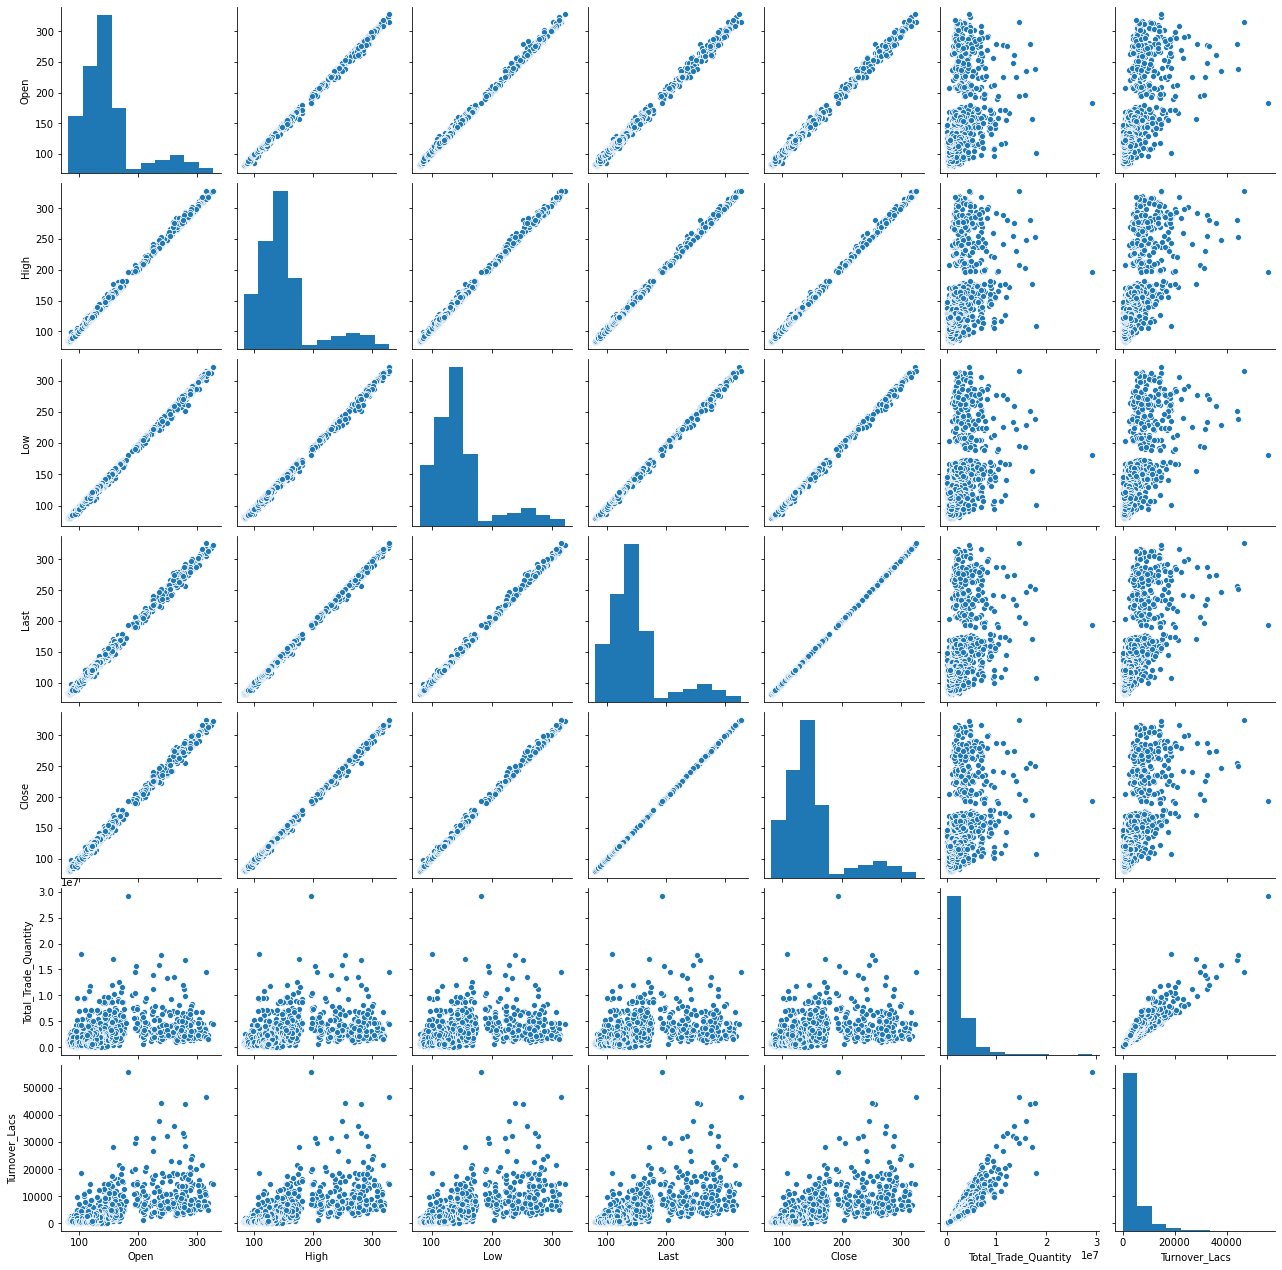

In [4]:
sns.distplot(df['Open'], hist = True, color = 'r')
plt.show()
sns.distplot(df['High'], hist = True, color = 'r')
plt.show()
sns.distplot(df['Low'], hist = True, color = 'r')
plt.show()
sns.distplot(df['Last'], hist = True, color = 'r')
plt.show()
sns.distplot(df['Total_Trade_Quantity'], hist = True, color = 'r')
plt.show()
sns.distplot(df['Turnover_Lacs'], hist = True, color = 'r')
plt.show()

sns_heat = sns.heatmap(df.corr(), annot = True)
# plt.savefig('E:/Forecast/2.jpg', format='jpg', dpi=1000)
sns_pair = sns.pairplot(df)
# plt.savefig('E:/Forecast/3.jpg', format='jpg', dpi=1000)

## Data Preprocessing

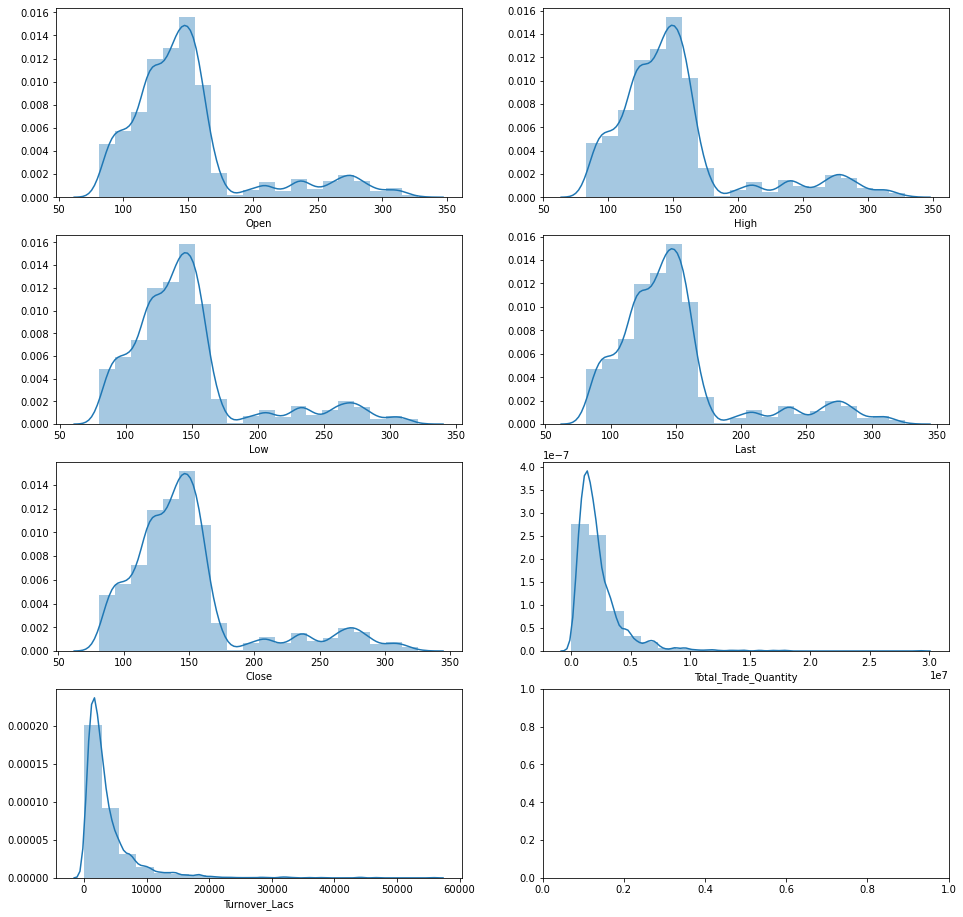

In [5]:
# Checking data distribution:

fig, ax = plt.subplots(4,2, figsize=(16,16))
sns.distplot(Dataset.Open, bins = 20, ax=ax[0,0]) 
sns.distplot(Dataset.High, bins = 20, ax=ax[0,1]) 
sns.distplot(Dataset.Low, bins = 20, ax=ax[1,0]) 
sns.distplot(Dataset.Last, bins = 20, ax=ax[1,1]) 
sns.distplot(Dataset.Close, bins = 20, ax=ax[2,0])
sns.distplot(Dataset.Total_Trade_Quantity, bins = 20, ax=ax[2,1])
sns.distplot(Dataset.Turnover_Lacs, bins = 20, ax=ax[3,0]) 

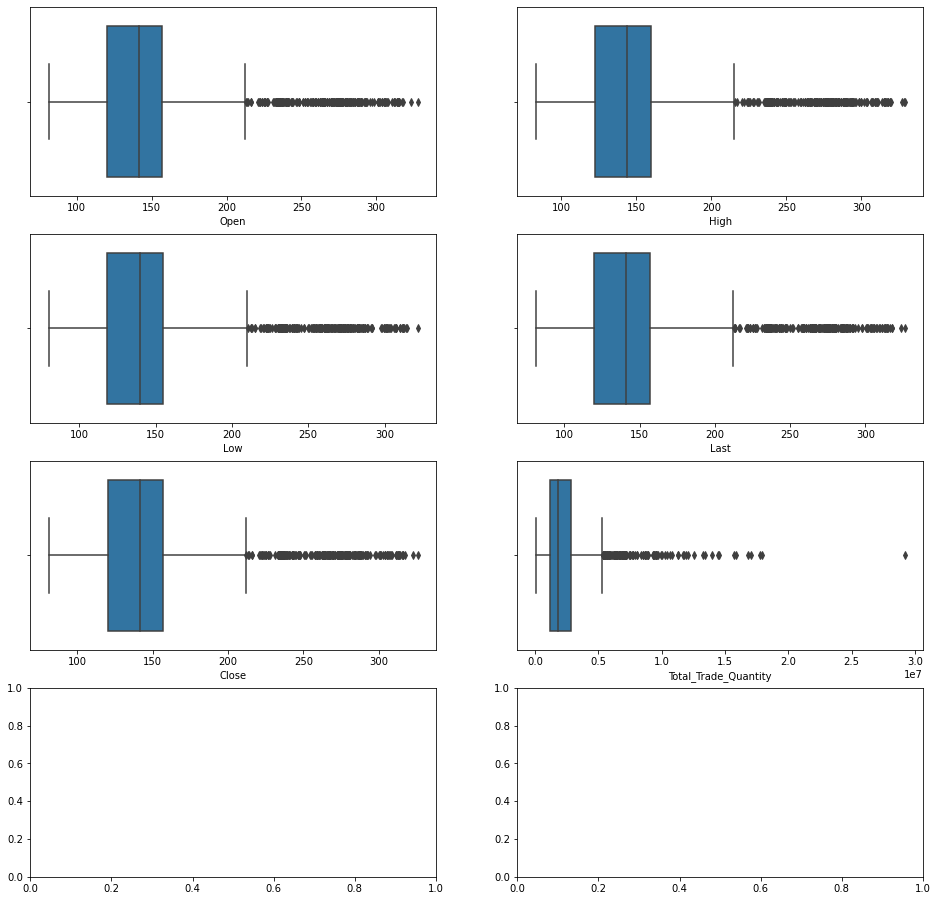

In [6]:
# checking outliers
columns = list(Dataset.columns)[:-1]
fig, ax = plt.subplots(4,2, figsize=(16,16))

for idx, col in enumerate(columns):
    sns.boxplot(data = Dataset, x = col, ax=ax[idx//2, idx % 2])
plt.show()


In [7]:
#tranforming the data using Quantile transformation
X = Dataset.iloc[:, :]
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
X_qt = qt.fit_transform(X)
X_qt_df = pd.DataFrame(X_qt, columns=X.columns)

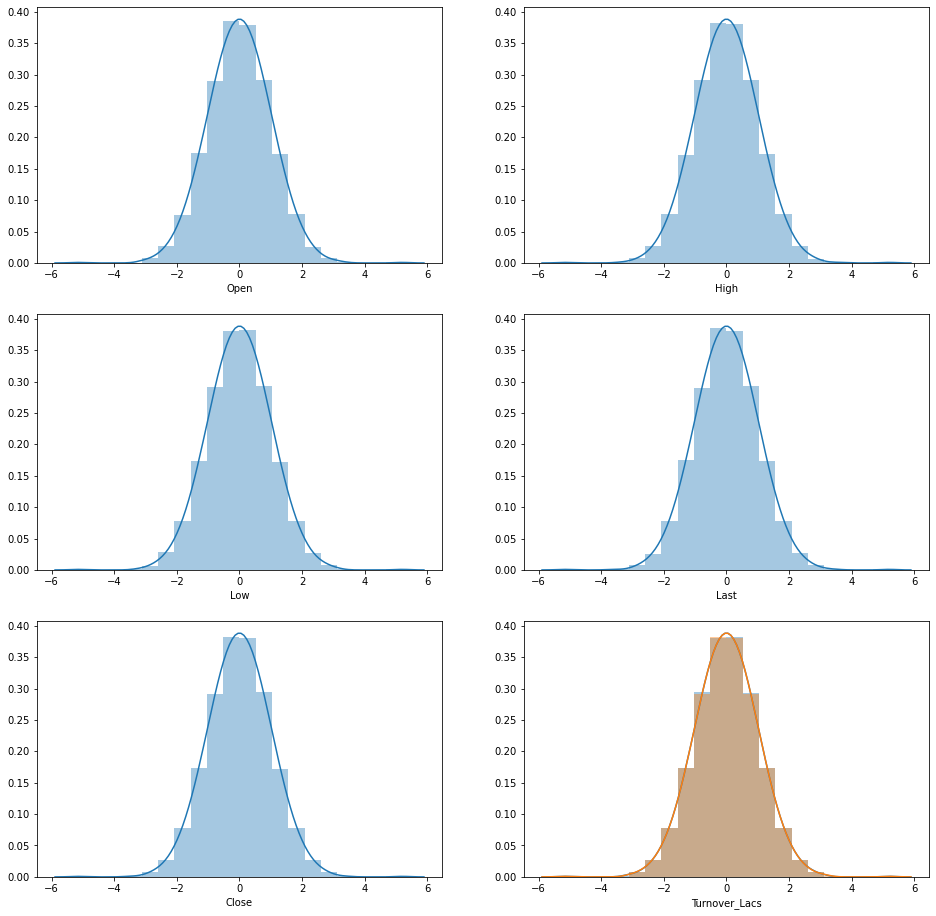

In [8]:
# Checking data distribution:

fig, ax = plt.subplots(3,2, figsize=(16,16))
sns.distplot(X_qt_df.Open, bins = 20, ax=ax[0,0]) 
sns.distplot(X_qt_df.High, bins = 20, ax=ax[0,1]) 
sns.distplot(X_qt_df.Low, bins = 20, ax=ax[1,0]) 
sns.distplot(X_qt_df.Last, bins = 20, ax=ax[1,1]) 
sns.distplot(X_qt_df.Close, bins = 20, ax=ax[2,0])
sns.distplot(X_qt_df.Total_Trade_Quantity, bins = 20, ax=ax[2,1])
sns.distplot(X_qt_df.Turnover_Lacs, bins = 20, ax=ax[2,1])

1526
Dimension of Training Data:  (1526, 7)
Dimension of Testing Data:  (509, 7)
X_train.shape:  (1516, 10, 6)
y_train.shape:  (1516, 1)
X_test.shape:  (499, 10, 6)
y_test.shape:  (499, 1)


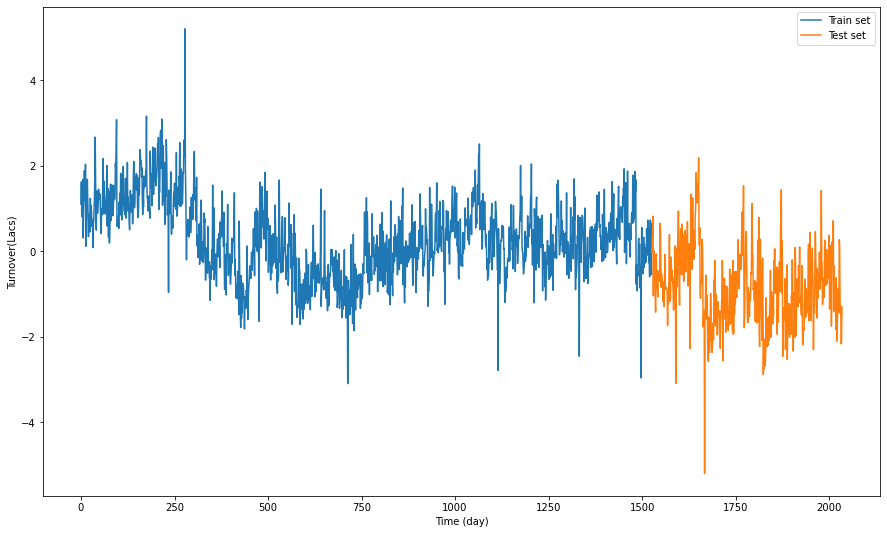

In [9]:
#+++++++++++++++++++++++++++++Splitting Data+++++++++++++++++++++++++++
train_size = int(len(X_qt_df) * 0.75)
print(train_size)
training_data, testing_data = X_qt_df.iloc[:train_size], X_qt_df.iloc[train_size:]

#+++++++++++++++++++++++Plotting Train and Test Data+++++++++++++++++++
plt.figure(figsize = (15, 9))
plt.plot(training_data.Turnover_Lacs)
plt.plot(testing_data.Turnover_Lacs)
plt.xlabel('Time (day)')
plt.ylabel('Turnover(Lacs)')
plt.legend(['Train set', 'Test set'], loc='upper right')

print('Dimension of Training Data: ',training_data.shape)
print('Dimension of Testing Data: ', testing_data.shape)


Train_X = training_data.drop('Turnover_Lacs', axis = 1)
Train_Y = training_data.loc[:, ['Turnover_Lacs']]

Test_X = testing_data.drop('Turnover_Lacs', axis = 1)
Test_Y = testing_data.loc[:, ['Turnover_Lacs']]

Train_X = Train_X.to_numpy()
Train_Y = Train_Y.to_numpy()
Test_X = Test_X.to_numpy()
Test_Y = Test_Y.to_numpy()

#+++++++++++++++++++++++Creating Dataset++++++++++++++++++++++++++++
def create_dataset(X, y, time_steps = 1):
    X_list, y_list = [], []
    for i in range(len(X) - time_steps):
        v = X[i:i + time_steps, :]
        X_list.append(v)
        y_list.append(y[i+time_steps])
    return np.array(X_list), np.array(y_list)

Time_steps = 10

X_train, y_train = create_dataset(Train_X, Train_Y, Time_steps)
X_test, y_test = create_dataset(Test_X, Test_Y, Time_steps)


print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

## Model Building and Fitting

In [10]:
def create_GRU_LSTM_model(m, units):

    model = Sequential()
    model.add(m(units = units, input_shape = [X_train.shape[1], X_train.shape[2]], kernel_regularizer = l2(0.0001), return_sequences = True))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(m(units = units))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
    return model

def create_BiLSTM_model(units):

    model = Sequential()
    model.add(Bidirectional(LSTM(units = units, kernel_regularizer = l2(0.0001),return_sequences=True),input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(units = 1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

model_gru = create_GRU_LSTM_model(GRU, 64)
model_lstm = create_GRU_LSTM_model(LSTM, 64)
model_bilstm = create_BiLSTM_model(64)

def fit_model(model):
    early_stop = callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    history = model.fit(X_train, y_train, epochs = 400, validation_split = 0.2, batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history

history_gru = fit_model(model_gru)
history_lstm = fit_model(model_lstm)
history_bilstm = fit_model(model_bilstm)

Epoch 1/400
38/38 [==============================] - 9s 224ms/step - loss: 0.6815 - val_loss: 0.5550
Epoch 2/400
38/38 [==============================] - 1s 38ms/step - loss: 0.5369 - val_loss: 0.4167
Epoch 3/400
38/38 [==============================] - 1s 34ms/step - loss: 0.4779 - val_loss: 0.4566
Epoch 4/400
38/38 [==============================] - 2s 45ms/step - loss: 0.4487 - val_loss: 0.4205
Epoch 5/400
38/38 [==============================] - 1s 38ms/step - loss: 0.4422 - val_loss: 0.4350
Epoch 6/400
38/38 [==============================] - 1s 30ms/step - loss: 0.4327 - val_loss: 0.4204
Epoch 7/400
38/38 [==============================] - 1s 30ms/step - loss: 0.4270 - val_loss: 0.4313
Epoch 8/400
38/38 [==============================] - 1s 35ms/step - loss: 0.4333 - val_loss: 0.4202
Epoch 9/400
38/38 [==============================] - 1s 33ms/step - loss: 0.4297 - val_loss: 0.4291: 0s - loss: 
Epoch 10/400
38/38 [==============================] - 1s 33ms/step - loss: 0.4362 - va

## Plotting and Predictions

[[-0.6720626 ]
 [-0.95325387]
 [-0.59767973]
 [-0.4326507 ]
 [-0.7270828 ]
 [-0.60478383]
 [-0.8044824 ]
 [-0.8708624 ]
 [-0.65527815]
 [-0.68526524]
 [-0.62336695]
 [-0.67620105]
 [-0.5175484 ]
 [-0.25400445]
 [-0.22331795]
 [-0.34759492]
 [-0.5902403 ]
 [-0.5014782 ]
 [-0.5799826 ]
 [-0.6956097 ]
 [-0.80665654]
 [-0.96602774]
 [-0.9302662 ]
 [-0.78406096]
 [-1.0043415 ]
 [-0.78188276]
 [-0.5338364 ]
 [-0.7292672 ]
 [-0.757028  ]
 [-0.7675734 ]
 [-0.75685054]
 [-0.7894506 ]
 [-0.839563  ]
 [-1.1412275 ]
 [-0.98841816]
 [-1.0484996 ]
 [-0.95992726]
 [-0.7199982 ]
 [-0.45219466]
 [-0.7940811 ]
 [-0.8521339 ]
 [-0.84347755]
 [-0.54416007]
 [-0.53372437]
 [-0.6528118 ]
 [-0.5762504 ]
 [-0.63144225]
 [-0.7045114 ]
 [-0.84137803]
 [-1.0152003 ]
 [-1.0245454 ]
 [-0.84907144]
 [-0.7641216 ]
 [-0.4777604 ]
 [-0.74278426]
 [-1.3416398 ]
 [-1.057416  ]
 [-0.62720186]
 [-0.8178947 ]
 [-0.794573  ]
 [-0.41722313]
 [-0.25197577]
 [-0.15975216]
 [-0.20166303]
 [-0.54275066]
 [-0.7597404 ]
 [-0.30733

[[-0.72830105]
 [-0.9699238 ]
 [-0.5908363 ]
 [-0.48353603]
 [-0.81291044]
 [-0.6134103 ]
 [-0.8706698 ]
 [-0.9486454 ]
 [-0.73733443]
 [-0.7542805 ]
 [-0.66328347]
 [-0.7311617 ]
 [-0.57772756]
 [-0.31012955]
 [-0.19502537]
 [-0.3476866 ]
 [-0.6051513 ]
 [-0.47786754]
 [-0.5751506 ]
 [-0.68488723]
 [-0.77756864]
 [-0.95679754]
 [-0.9175002 ]
 [-0.82465845]
 [-1.1448156 ]
 [-0.8543032 ]
 [-0.61962277]
 [-0.85877496]
 [-0.85126936]
 [-0.87775296]
 [-0.8639203 ]
 [-0.88235533]
 [-0.93318844]
 [-1.3286836 ]
 [-1.0504241 ]
 [-1.1806401 ]
 [-1.0639439 ]
 [-0.8198279 ]
 [-0.5552646 ]
 [-1.0295177 ]
 [-1.012283  ]
 [-1.0100753 ]
 [-0.66142696]
 [-0.6272529 ]
 [-0.7125826 ]
 [-0.57402825]
 [-0.6141789 ]
 [-0.71140945]
 [-0.9078179 ]
 [-1.1126072 ]
 [-1.0773337 ]
 [-0.8895806 ]
 [-0.8102672 ]
 [-0.5409312 ]
 [-0.87797457]
 [-1.5177364 ]
 [-1.1753023 ]
 [-0.7777404 ]
 [-0.9894487 ]
 [-0.8837424 ]
 [-0.5256799 ]
 [-0.32205978]
 [-0.1042248 ]
 [-0.09340504]
 [-0.5784623 ]
 [-0.79837525]
 [-0.40894

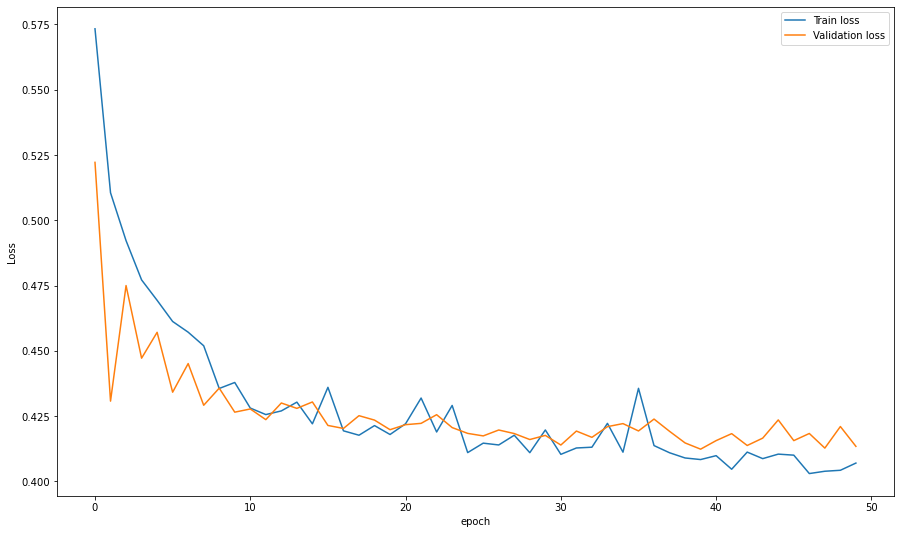

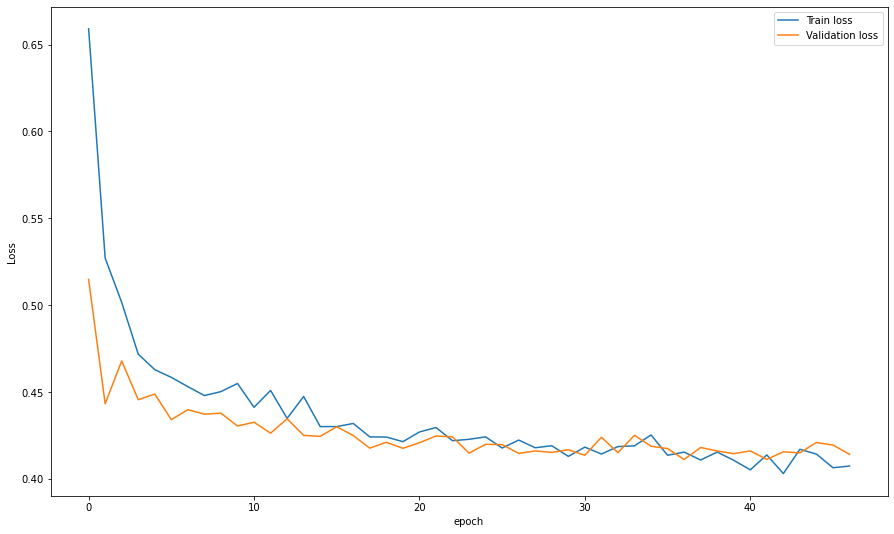

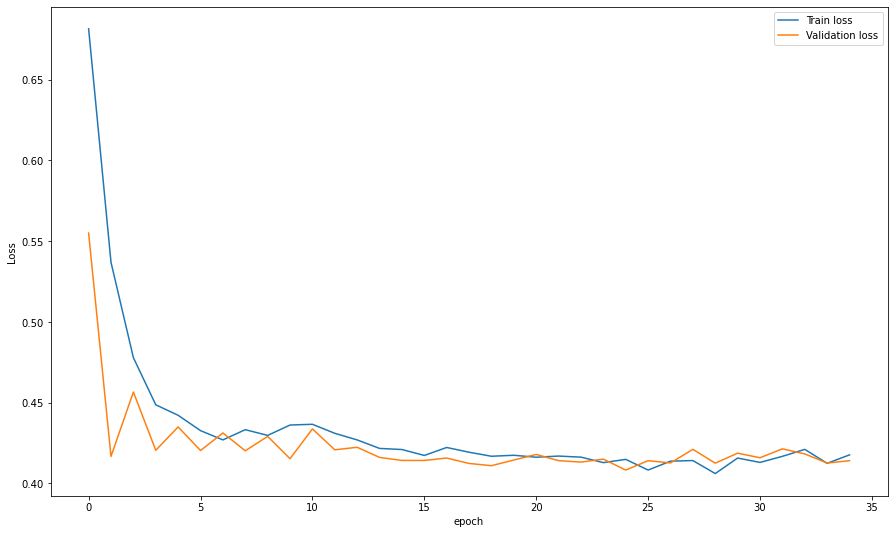

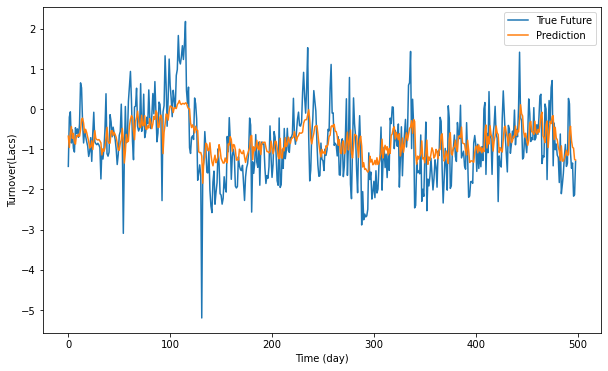

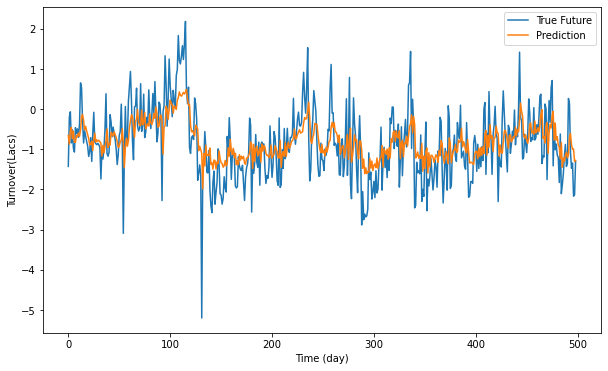

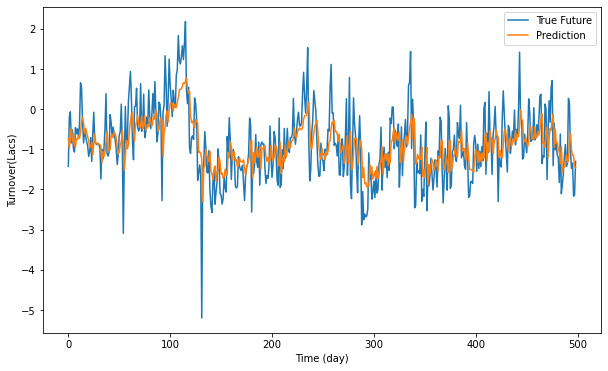

In [35]:
# Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (15, 9))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_bilstm)
plot_loss (history_lstm)
plot_loss (history_gru)

def prediction(model):
    prediction = model.predict(X_test)
    return prediction

prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)


# Plot true future vs prediction
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')     
    plt.plot(np.arange(range_future),np.array(prediction),label='Prediction')
    plt.legend(loc='upper right')
    plt.xlabel('Time (day)')
    plt.ylabel('Turnover(Lacs)')
    plt.savefig('E:/Forecast/4.jpg', format='jpg', dpi=1000)
    
plot_future(prediction_bilstm, y_test)
plot_future(prediction_lstm, y_test)
plot_future(prediction_gru, y_test)

def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')

In [12]:
# Import climate data projection
import pandas as pd
newinput = pd.read_csv('Test_Data.csv', parse_dates=['Date'], index_col = 'Date')
newinput.sort_index(inplace=True)
newinput.head()


,Open,High,Low,Last,Close,Total_Trade_Quantity,Turnover_Lacs
Date,,,,,,,
2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [13]:
# Plot histoy and future data
def plot_history_future(y_train, prediction, model_name):
    
    plt.figure(figsize=(10, 6))
    
    range_history = len(y_train)
    range_future = list(range(range_history, range_history + len(prediction)))

    plt.plot(np.arange(range_history), np.array(y_train), label='History')
    plt.plot(range_future, np.array(prediction),label='Prediction')

    plt.title('History and prediction for ' + model_name)
    plt.legend(loc='upper right')
    plt.xlabel('Time (day)')
    plt.ylabel('TurnOver Lacs')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/3.jpg', format='jpg', dpi=1000)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2367: UserWarning: n_quantiles (1000) is greater than the total number of samples (553). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2367: UserWarning: n_quantiles (1000) is greater than the total number of samples (553). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


(553, 6)
[[[ 0.90410066  0.8122178   0.97469788  0.87044371  0.91095546
   -0.80591848]
  [ 0.78720919  0.72673011  0.94589352  0.84097432  0.86053762
   -1.81946459]
  [ 0.88043595  0.72082939  0.94589352  0.78720919  0.81854952
   -1.92405391]
  ...
  [ 0.46587588  0.43571506  0.49133659  0.45325891  0.45829693
    1.15919475]
  [ 0.52752928  0.45577647  0.66596295  0.62402876  0.56442671
   -0.79341473]
  [ 0.61303216  0.59125761  0.78103381  0.66313144  0.65185804
   -0.96019612]]

 [[ 0.78720919  0.72673011  0.94589352  0.84097432  0.86053762
   -1.81946459]
  [ 0.88043595  0.72082939  0.94589352  0.78720919  0.81854952
   -1.92405391]
  [ 0.78103381  0.68593575  0.72082939  0.54062205  0.58855561
   -0.82491422]
  ...
  [ 0.52752928  0.45577647  0.66596295  0.62402876  0.56442671
   -0.79341473]
  [ 0.61303216  0.59125761  0.78103381  0.66313144  0.65185804
   -0.96019612]
  [ 0.62678969  0.50418635  0.6021092   0.49903657  0.49646664
   -0.27120693]]

 [[ 0.88043595  0.72082939 

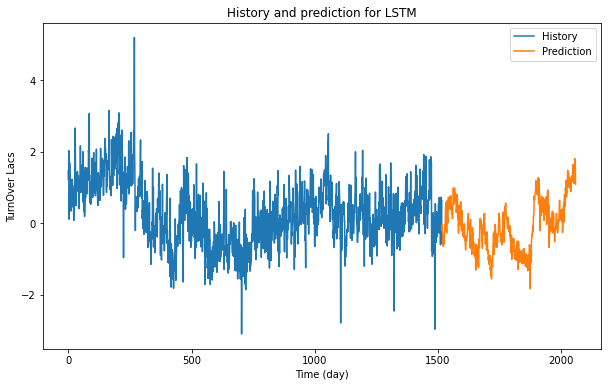

In [37]:
Time_steps = 10
def forecast(X_input, time_steps):
    # Scale the unseen input with the scaler fitted on the training data
    X = qt.fit_transform(X_input)
    X = pd.DataFrame(X,columns=newinput.columns)
    X = X.drop('Turnover_Lacs', axis = 1)
    Y = newinput.loc[:, ['Turnover_Lacs']]
    y_transform = qt.fit_transform(Y)
    X = X.to_numpy()
    Xs = []

    # Reshape unseen data to a 3D input
    def create_dataset(X,time_steps = 1):
        Xs = []
        for i in range(len(X) - time_steps):
            v = X[i:i + time_steps, :]
            Xs.append(v)
        return np.array(Xs)
    X_transformed = create_dataset(X, Time_steps)

    # Make prediction for unseen data using LSTM model 
    prediction = model_lstm.predict(X_transformed)
    return prediction

prediction = forecast(newinput, Time_steps)
plot_history_future(y_train, prediction,'LSTM')